#### 1. Importing necessary libraries

In [126]:
# %pip install numpy pandas sqlalchemy seaborn matplotlib ydata-profiling scikit-learn
%matplotlib inline

import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport
from scipy.stats import shapiro
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

postgres_username = 'postgres'
postgres_password = 'password'
postgres_host = 'localhost'
postgres_port = '5432'
postgres_database = 'agrictrl'

engine = create_engine(f'postgresql://{postgres_username}:{postgres_password}@{postgres_host}:{postgres_port}/{postgres_database}')


#### 2. Extracting raw data

In [99]:
raw_df_pest = pd.read_csv('data/pesticides.csv')
raw_df_rain = pd.read_csv('data/rainfall.csv')
raw_df_temp = pd.read_csv('data/temp.csv')
raw_df_yield = pd.read_csv('data/yield.csv')

display(raw_df_pest.head())
display(raw_df_rain.head())
display(raw_df_temp.head())
display(raw_df_yield.head())

,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327


,year,country,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


Check for duplicates and null values

#### 3. Transform data

Column names are consistent and formatted


In [100]:
def format_columns(df):
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
    return df

raw_df_pest = format_columns(raw_df_pest)
raw_df_rain = format_columns(raw_df_rain)
raw_df_temp = format_columns(raw_df_temp)
raw_df_yield = format_columns(raw_df_yield)

Entries with duplicate, null, and invalid data are removed

In [101]:
# Upon inspection, raw_df_rain has values that are not numbers
raw_df_rain['average_rain_fall_mm_per_year'] = raw_df_rain['average_rain_fall_mm_per_year'].replace('..', np.nan)

In [102]:
def check_and_clean(df, name):
    print(f"{name} shape before cleaning:", df.shape)
    print(f"{name} duplicates:", df.duplicated().sum())
    print(f"{name} null values:") 
    print(df.isnull().sum())

    df = df.drop_duplicates()
    df = df.dropna()
    
    print(f"{name} shape after cleaning:", df.shape)
    print()
    return df

raw_df_pest = check_and_clean(raw_df_pest, "raw_df_pest")
raw_df_rain = check_and_clean(raw_df_rain, "raw_df_rain")
raw_df_temp = check_and_clean(raw_df_temp, "raw_df_temp")
raw_df_yield = check_and_clean(raw_df_yield, "raw_df_yield")

raw_df_pest shape before cleaning: (4349, 7)
raw_df_pest duplicates: 0
raw_df_pest null values:
domain     0
area       0
element    0
item       0
year       0
unit       0
value      0
dtype: int64
raw_df_pest shape after cleaning: (4349, 7)

raw_df_rain shape before cleaning: (6727, 3)
raw_df_rain duplicates: 0
raw_df_rain null values:
area                               0
year                               0
average_rain_fall_mm_per_year    780
dtype: int64
raw_df_rain shape after cleaning: (5947, 3)

raw_df_temp shape before cleaning: (71311, 3)
raw_df_temp duplicates: 6958
raw_df_temp null values:
year           0
country        0
avg_temp    2547
dtype: int64
raw_df_temp shape after cleaning: (62976, 3)

raw_df_yield shape before cleaning: (56717, 12)
raw_df_yield duplicates: 0
raw_df_yield null values:
domain_code     0
domain          0
area_code       0
area            0
element_code    0
element         0
item_code       0
item            0
year_code       0
year            0

Columns have appropriate data types

In [103]:
def print_dtypes(df, name):
    print(f"\n{name} dtypes:")
    print(df.dtypes)

print_dtypes(raw_df_pest, "raw_df_pest")
print_dtypes(raw_df_rain, "raw_df_rain")
print_dtypes(raw_df_temp, "raw_df_temp")
print_dtypes(raw_df_yield, "raw_df_yield")


raw_df_pest dtypes:
domain      object
area        object
element     object
item        object
year         int64
unit        object
value      float64
dtype: object

raw_df_rain dtypes:
area                             object
year                              int64
average_rain_fall_mm_per_year    object
dtype: object

raw_df_temp dtypes:
year          int64
country      object
avg_temp    float64
dtype: object

raw_df_yield dtypes:
domain_code     object
domain          object
area_code        int64
area            object
element_code     int64
element         object
item_code        int64
item            object
year_code        int64
year             int64
unit            object
value            int64
dtype: object


In [104]:
raw_df_rain['average_rain_fall_mm_per_year'] = raw_df_rain['average_rain_fall_mm_per_year'].astype('float64')

Normalization of data to organize entities

In [ ]:
# Normalization of tables
df_country = raw_df_yield[['area_code', 'area']].drop_duplicates().reset_index(drop=True)
df_country = df_country.rename(columns={'area_code': 'country_code', 'area': 'country'})
df_item = raw_df_yield[['item_code', 'item']].drop_duplicates().reset_index(drop=True)

# Domain and Element are dropped due to unneeded context
# Context is already provided by the tables
df_yield = raw_df_yield.copy()
df_yield = df_yield.drop(columns=['domain', 'domain_code', 'element', 'element_code', 'area', 'element', 'item', 'year_code', 'unit'])
df_yield = df_yield.rename(columns={'area_code': 'country_code', 'value': 'hg/ha_yield'})

# Item in raw_df_pest is the same for all (Pesticide)
# Rename value to have unit measurement
df_pest = raw_df_pest.copy()
df_pest = df_pest.drop(columns=['domain', 'element', 'item', 'unit'])
df_pest = df_pest.rename(columns={'area': 'country', 'value': 'pesticides_tonnes'})
df_pest = df_country.merge(df_pest, on='country', how='inner')
df_pest = df_pest.drop(columns=['country'])

# Normalize raw_df_rain
df_rain = raw_df_rain.copy()
df_rain = df_rain.rename(columns={'area': 'country', 'average_rain_fall_mm_per_year': 'avg_rainfall_mm'})
df_rain = df_country.merge(df_rain, on='country', how='inner')
df_rain = df_rain.drop(columns=['country'])

# Normalize raw_df_temp
df_temp = raw_df_temp.copy()
df_temp = df_temp.rename(columns={'avg_temp': 'avg_temp_celsius'})
df_temp = df_country.merge(df_temp, on='country', how='inner')
df_temp = df_temp.drop(columns=['country'])

# Display normalized tables
display(df_country.head())
display(df_item.head())
display(df_yield.head())
display(df_pest.head())
display(df_rain.head())
display(df_temp.head())

,area_code,area
0,2,Afghanistan
1,3,Albania
2,4,Algeria
3,5,American Samoa
4,7,Angola


,item_code,item
0,56,Maize
1,116,Potatoes
2,27,"Rice, paddy"
3,15,Wheat
4,83,Sorghum


,area_code,item_code,year,hg/ha_yield
0,2,56,1961,14000
1,2,56,1962,14000
2,2,56,1963,14260
3,2,56,1964,14257
4,2,56,1965,14400


,area_code,year,pesticides_tonnes
0,3,1990,121.0
1,3,1991,121.0
2,3,1992,121.0
3,3,1993,121.0
4,3,1994,201.0


,area_code,year,avg_rainfall_mm
0,2,1985,327.0
1,2,1986,327.0
2,2,1987,327.0
3,2,1989,327.0
4,2,1990,327.0


,area_code,year,country,avg_temp_celsius
0,2,1833,Afghanistan,13.91
1,2,1834,Afghanistan,13.91
2,2,1835,Afghanistan,14.71
3,2,1837,Afghanistan,15.47
4,2,1838,Afghanistan,18.50


#### 4. Loading transformed data into PostgreSQL

In [ ]:
df_country.to_sql('Country', engine, schema='public', if_exists='replace', index=False)
df_item.to_sql('Item', engine, schema='public', if_exists='replace', index=False)
df_yield.to_sql('Yield', engine, schema='public', if_exists='replace', index=False)
df_pest.to_sql('PesticideUse', engine, schema='public', if_exists='replace', index=False)
df_rain.to_sql('Rainfall', engine, schema='public', if_exists='replace', index=False)
df_temp.to_sql('Temperature', engine, schema='public', if_exists='replace', index=False)

480

#### 5. Analyze data
- Data analysis on Yields based on time, rainfall, temperature, and pesticide use


Data Query and Checking

In [ ]:
query = """
SELECT c.country, i.item, y.year, p.pesticides_tonnes, r.avg_rainfall_mm, t.avg_temp_celsius, y."hg/ha_yield"
FROM public."Yield" y
JOIN public."Country" c ON y.country_code = c.country_code
JOIN public."Item" i ON y.item_code = i.item_code
JOIN public."PesticideUse" p ON y.country_code = p.country_code AND y.year = p.year
JOIN public."Rainfall" r ON y.country_code = r.country_code AND y.year = r.year
JOIN public."Temperature" t ON y.country_code = t.country_code AND y.year = t.year
"""

df = pd.read_sql(query, engine)
display(df.head())
display(df.shape)

,area,item,year,pesticides_tonnes,avg_rainfall_mm,avg_temp_celsius,hg/ha_yield
0,Mexico,Wheat,2000,34468.93,758.0,19.29,49355
1,Brazil,Wheat,2007,304031.00,1761.0,27.92,22199
2,United Kingdom,Wheat,2011,16401.66,1220.0,9.82,77471
3,Japan,Wheat,1995,79821.18,1668.0,14.97,29319
4,Ireland,Wheat,1998,2257.00,1118.0,9.71,80310


(25932, 7)

In [108]:
df.describe()

,year,pesticides_tonnes,avg_rainfall_mm,avg_temp_celsius,hg/ha_yield
count,25932.000000,25932.000000,25932.000000,25932.000000,25932.000000
mean,2001.556455,34782.573241,1146.836688,20.422251,76978.132925
std,7.055924,57228.568244,717.391098,6.439402,84647.605552
min,1990.000000,0.040000,51.000000,1.300000,50.000000
25%,1995.000000,1597.000000,593.000000,16.580000,19996.000000
50%,2001.000000,15373.000000,1083.000000,21.420000,39530.000000
75%,2008.000000,45620.000000,1668.000000,26.060000,104168.000000
max,2013.000000,367778.000000,3240.000000,30.650000,501412.000000


In [ ]:
target_column = 'hg/ha_yield'
measured_columns = ['hg/ha_yield', 'avg_rainfall_mm', 'pesticides_tonnes', 'avg_temp_celsius']
entity_columns = ['country', 'item']
time_columns = ['year']

YData Profiling

In [110]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Data Distribution

In [ ]:
print("Crops:")
print(df['item'].value_counts())

In [ ]:
print("Countries:", df['country'].nunique())

Countries: 101


In [ ]:
print("Top 10 countries by yield:")
print(df.groupby(['country'],sort=True)['hg/ha_yield'].sum().nlargest(10))

Top 10 countries by yield:
area
India             274219558
Brazil            136340329
Mexico            113698872
Australia         109111062
Japan             100924145
Indonesia          68067328
Turkey             52263950
Pakistan           49264956
Spain              46773540
United Kingdom     44335992
Name: hg/ha_yield, dtype: int64


In [ ]:
print("Top 10 countries and items by yield:")
print(df.groupby(['item','country'],sort=True)['hg/ha_yield'].sum().nlargest(10))

Top 10 countries and items by yield:
item            area          
Cassava         India             119691113
Potatoes        India              77126500
                Australia          45670386
                Brazil             40335293
                United Kingdom     37364116
Sweet potatoes  India              37169811
Potatoes        Mexico             36559587
Sweet potatoes  Australia          35550294
Potatoes        Japan              34829648
Sweet potatoes  Mexico             31148282
Name: hg/ha_yield, dtype: int64


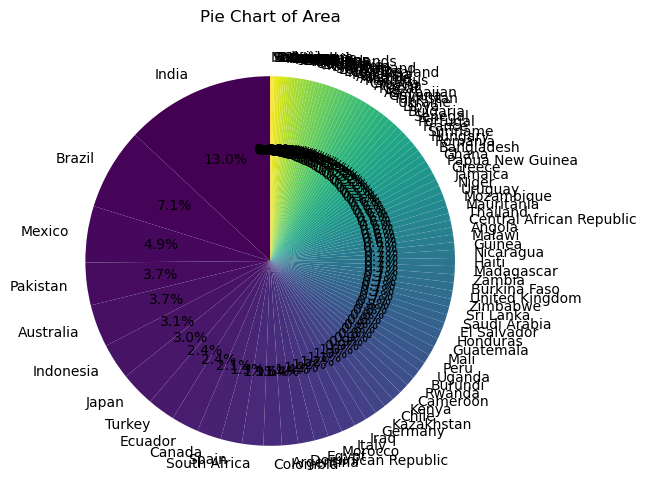

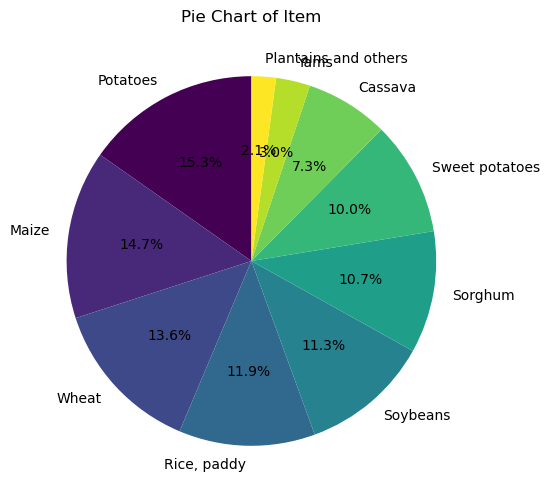

<Figure size 500x200 with 0 Axes>

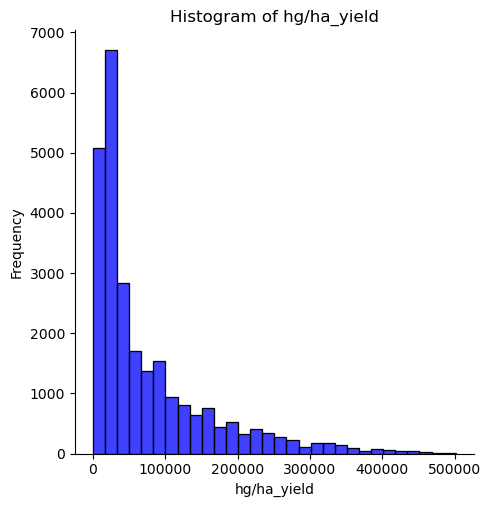

<Figure size 500x200 with 0 Axes>

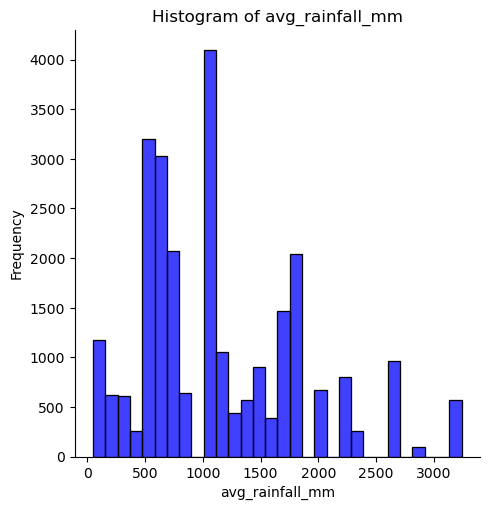

<Figure size 500x200 with 0 Axes>

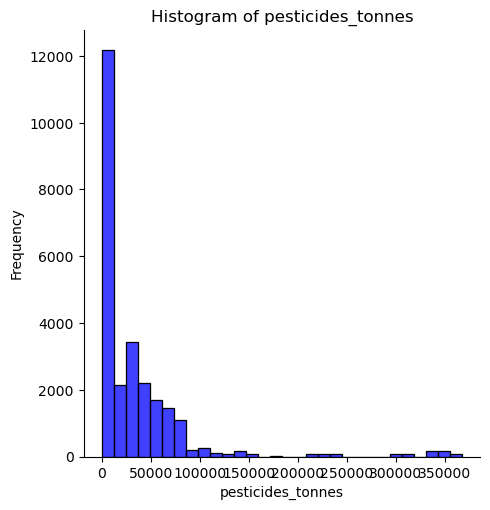

<Figure size 500x200 with 0 Axes>

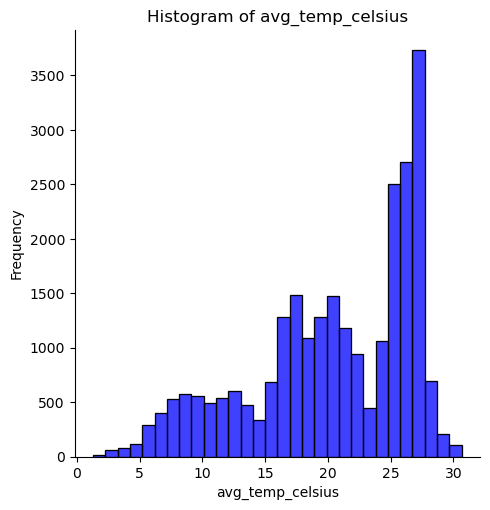

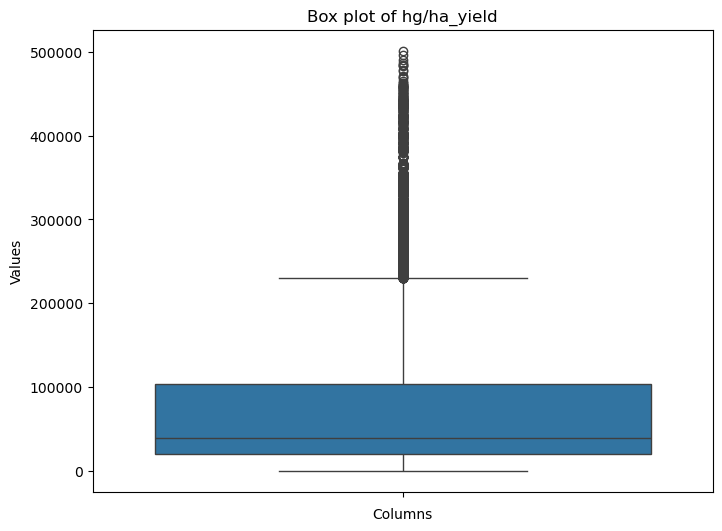

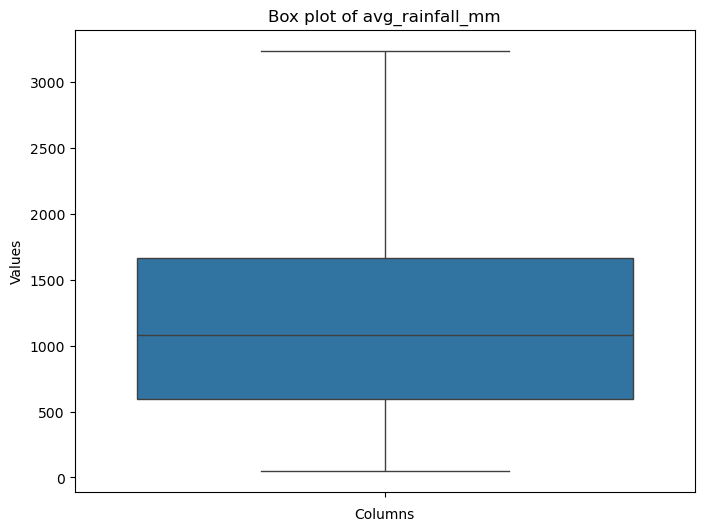

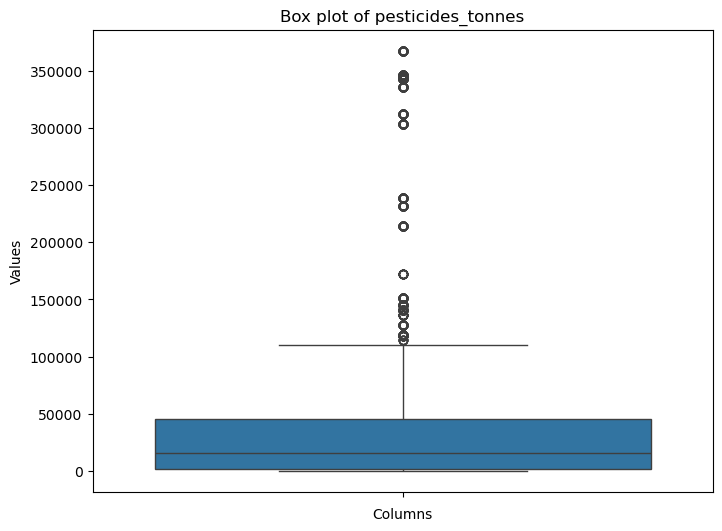

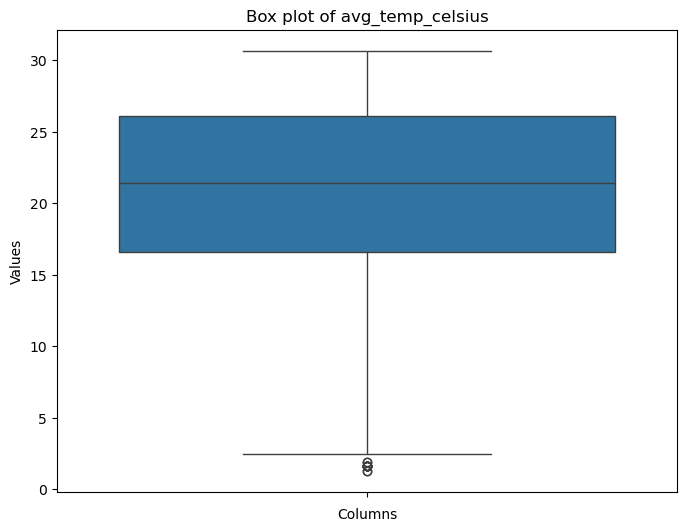

In [ ]:
for column in entity_columns:
    plt.figure(figsize=(10, 6))
    df[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
    plt.title(f'Pie Chart of {column.capitalize()}')
    plt.ylabel('')
    plt.show()

In [ ]:
for column in measured_columns:
    plt.figure(figsize=(5, 2))
    sns.displot(df[column], bins=30, kde=False, color='blue')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
for column in measured_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df[column])
    plt.title(f'Box plot of {column}')
    plt.xlabel('Columns')
    plt.ylabel('Values')
    plt.show()

In [143]:
from scipy.stats import anderson
for column in measured_columns:
    print('------------------------------------------------------------')
    stat, p = shapiro(df[column])
    print(f'Shapiro-Wilk Test for {column}: Statistics={stat:.3f}, p={p:.3f}')
    if p > 0.05:
        print(f'{column} follows a normal distribution (fail to reject H0)')
    else:
        print(f'{column} does not follows a normal distribution (reject H0)')
    print()

    result = anderson(df[column])
    stat = result.statistic
    critical_values = result.critical_values
    significance_level = result.significance_level

    print(f'Anderson-Darling Test for {column}: Statistics={stat:.3f}')
    if stat > critical_values[2]:  # Using the 5% significance level
        print(f'{column} does not follow a normal distribution')
    else:
        print(f'{column} follows a normal distribution')

------------------------------------------------------------
Shapiro-Wilk Test for hg/ha_yield: Statistics=0.774, p=0.000
hg/ha_yield does not follows a normal distribution (reject H0)

Anderson-Darling Test for hg/ha_yield: Statistics=1959.690
hg/ha_yield does not follow a normal distribution
------------------------------------------------------------
Shapiro-Wilk Test for avg_rainfall_mm: Statistics=0.931, p=0.000
avg_rainfall_mm does not follows a normal distribution (reject H0)

Anderson-Darling Test for avg_rainfall_mm: Statistics=535.053
avg_rainfall_mm does not follow a normal distribution
------------------------------------------------------------
Shapiro-Wilk Test for pesticides_tonnes: Statistics=0.581, p=0.000
pesticides_tonnes does not follows a normal distribution (reject H0)

Anderson-Darling Test for pesticides_tonnes: Statistics=2774.777
pesticides_tonnes does not follow a normal distribution
------------------------------------------------------------
Shapiro-Wilk Te

In [144]:
from scipy.stats import poisson, kstest

for column in measured_columns:
    # Fit a Poisson distribution to the data
    data = df[column]
    mu = data.mean()
    poisson_dist = poisson(mu)
    
    # Perform the Kolmogorov-Smirnov test
    stat, p_value = kstest(data, poisson_dist.cdf)
    
    print(f'Kolmogorov-Smirnov Test for {column}: Statistics={stat:.3f}, p-value={p_value:.3f}')
    if p_value > 0.05:
        print(f'{column} follows a Poisson distribution (fail to reject H0)')
    else:
        print(f'{column} does not follow a Poisson distribution (reject H0)')
    print()

Kolmogorov-Smirnov Test for hg/ha_yield: Statistics=0.659, p-value=0.000
hg/ha_yield does not follow a Poisson distribution (reject H0)

Kolmogorov-Smirnov Test for avg_rainfall_mm: Statistics=0.568, p-value=0.000
avg_rainfall_mm does not follow a Poisson distribution (reject H0)

Kolmogorov-Smirnov Test for pesticides_tonnes: Statistics=0.631, p-value=0.000
pesticides_tonnes does not follow a Poisson distribution (reject H0)

Kolmogorov-Smirnov Test for avg_temp_celsius: Statistics=0.239, p-value=0.000
avg_temp_celsius does not follow a Poisson distribution (reject H0)



Time Series Analysis

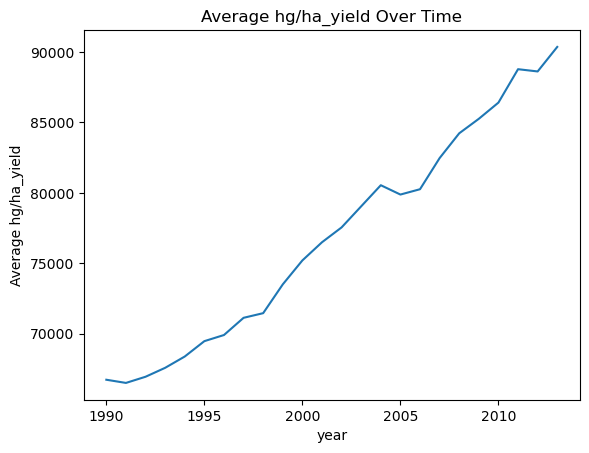

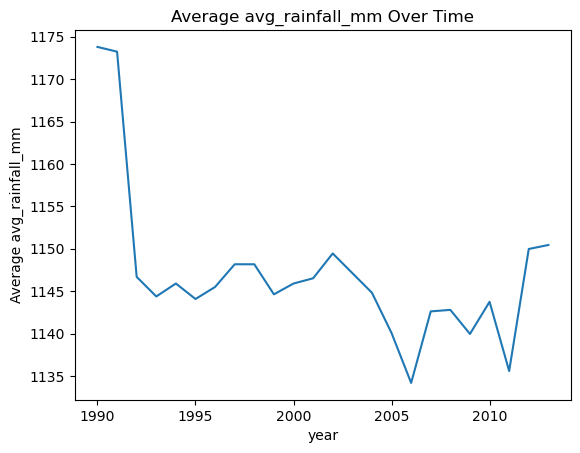

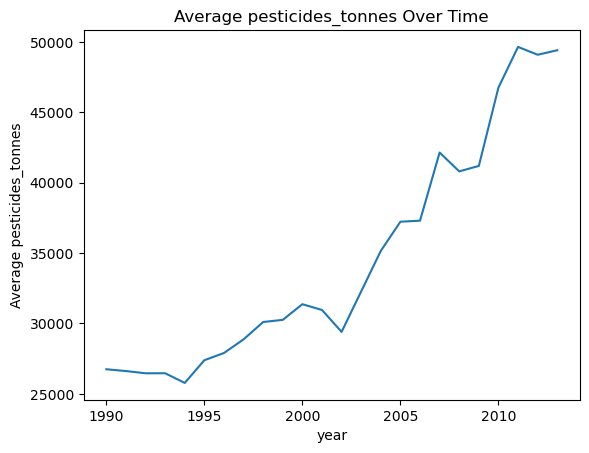

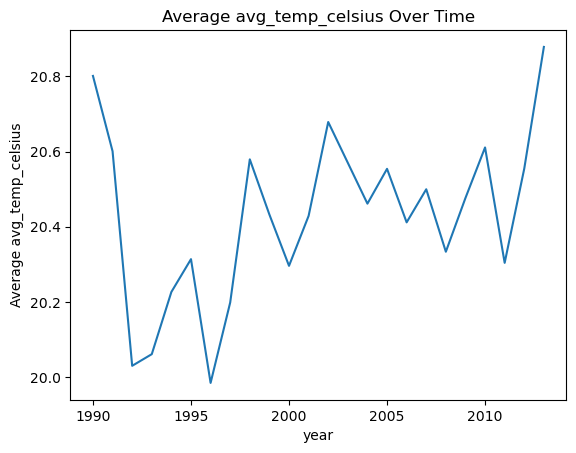

In [115]:
for column in measured_columns:
    df.groupby('year')[column].mean().plot()
    plt.title(f'Average {column} Over Time')
    plt.xlabel('year')
    plt.ylabel(f'Average {column}')
    plt.show()

Analysis of Yield to Entities

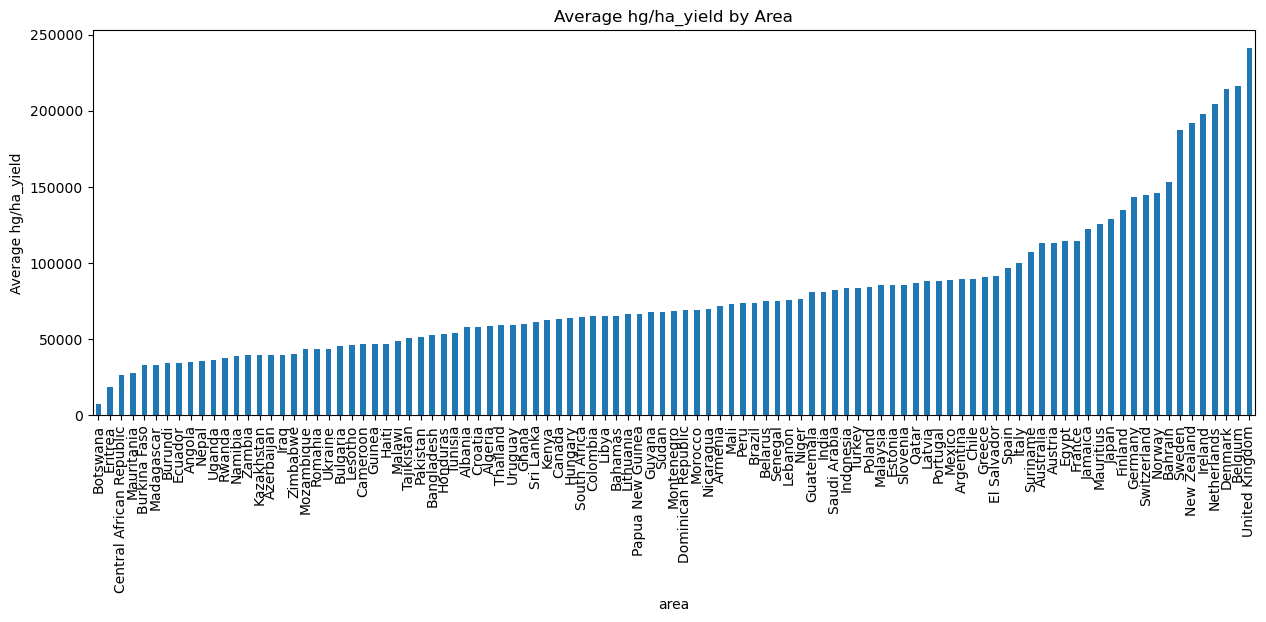

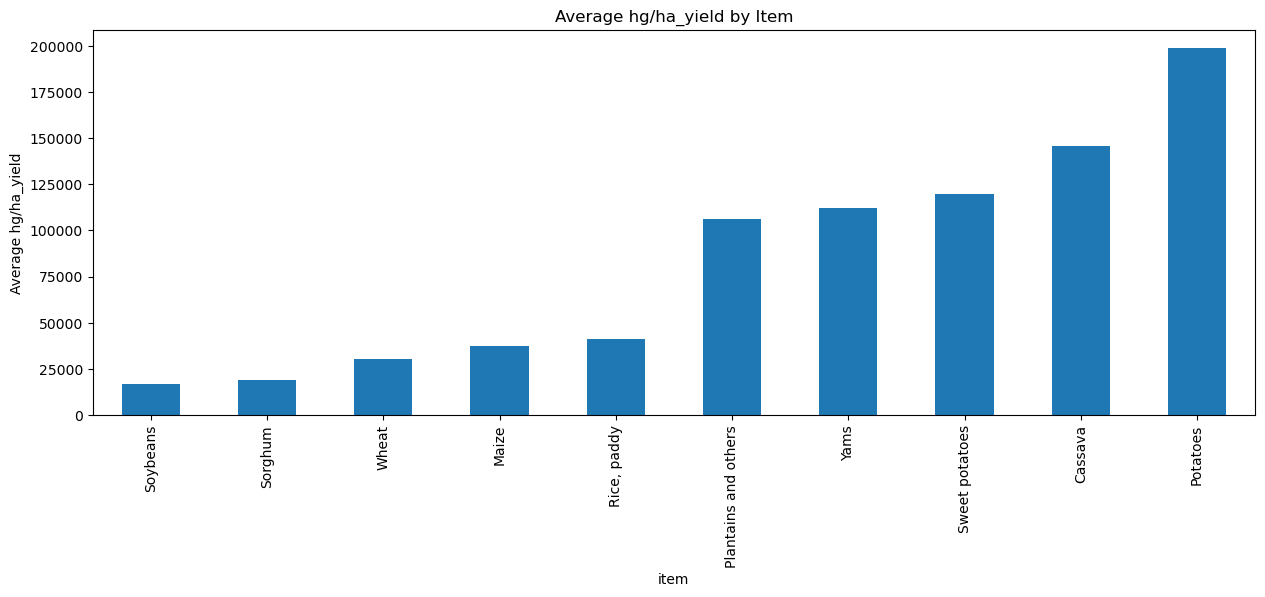

In [116]:
for column in entity_columns:
    df.groupby(column)['hg/ha_yield'].mean().sort_values().plot(kind='bar', figsize=(15, 5))
    plt.title(f'Average hg/ha_yield by {column.capitalize()}')
    plt.xlabel(column)
    plt.ylabel('Average hg/ha_yield')
    plt.show()


Heatmap

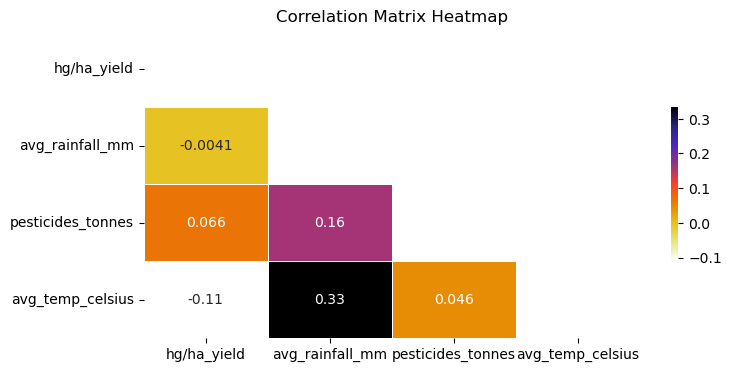

In [ ]:
# Create a correlation matrix
correlation_matrix = df[measured_columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(7, 4))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.CMRmap_r, mask=mask, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix Heatmap')
plt.show()

Pairplot

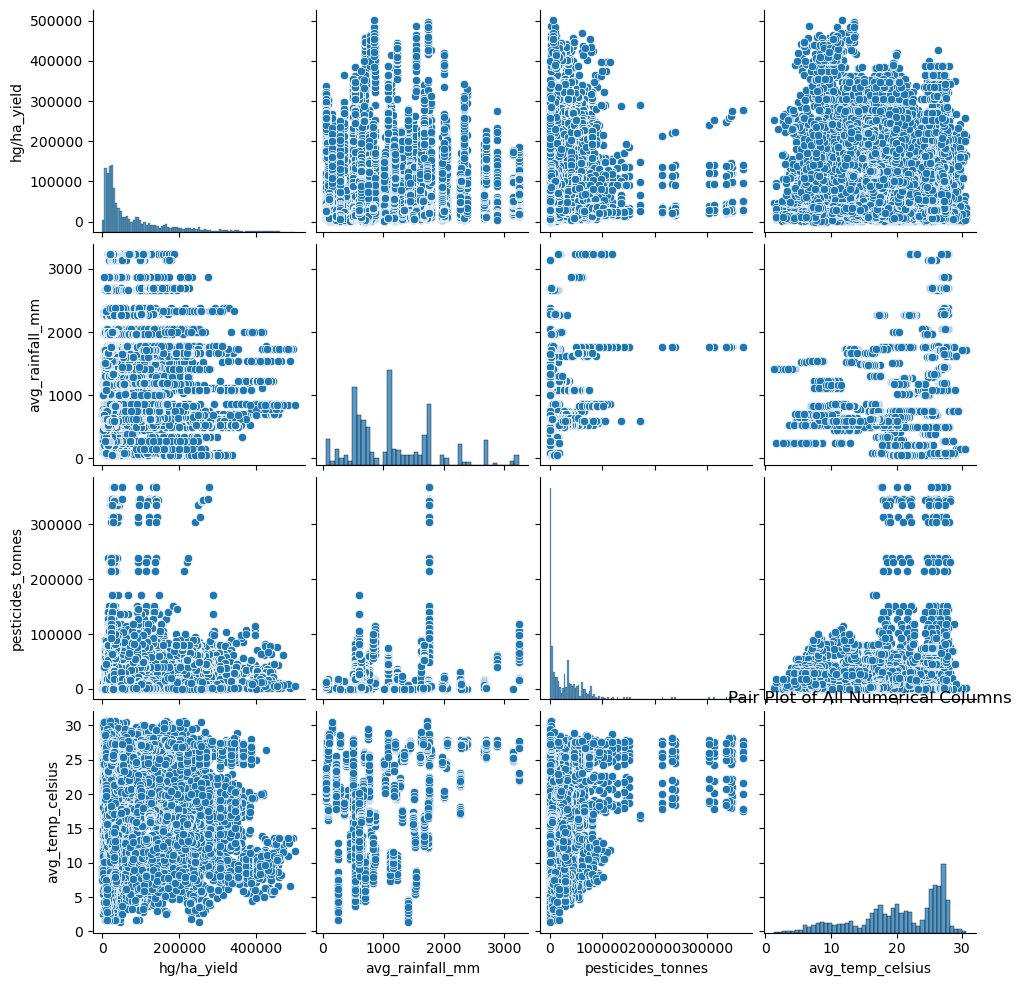

In [118]:
sns.pairplot(df[measured_columns])
plt.title('Pair Plot of All Numerical Columns')
plt.show()

#### 6. Apply machine learning

Encode and split data

In [119]:
# Encode categorical variables
label_encoder_area = LabelEncoder()
df['area'] = label_encoder_area.fit_transform(df['area'])

label_encoder_item = LabelEncoder()
df['item'] = label_encoder_item.fit_transform(df['item'])

# Define features and target variable
X = df.drop(columns=['hg/ha_yield'])
y = df['hg/ha_yield']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Evaluate models

Decision Tree
MSE: 172700227.8238, R²: 0.9759


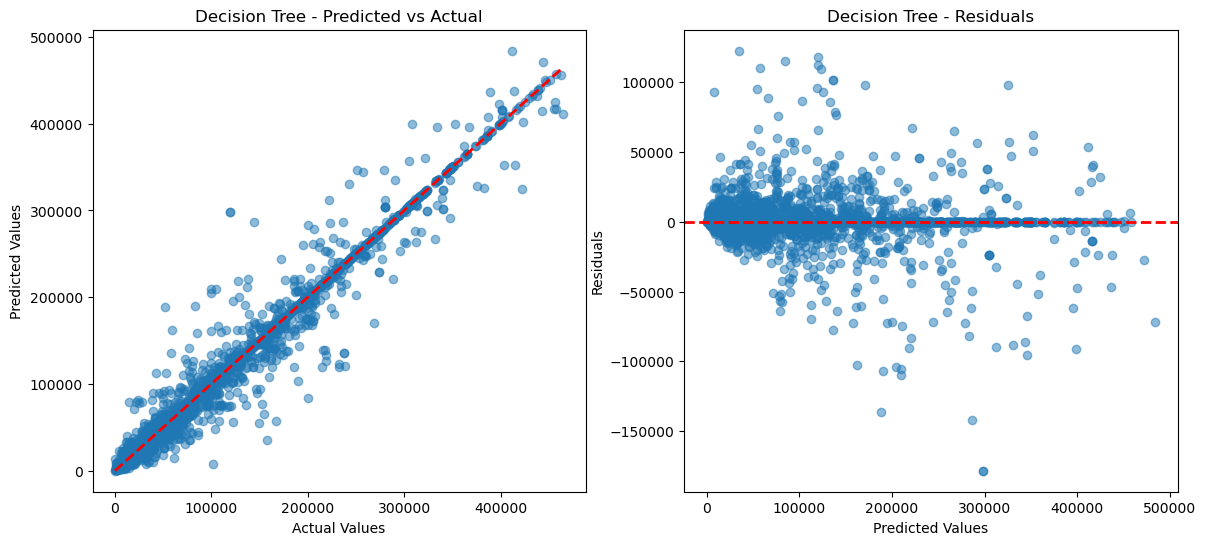

Random Forest
MSE: 98993421.9876, R²: 0.9862


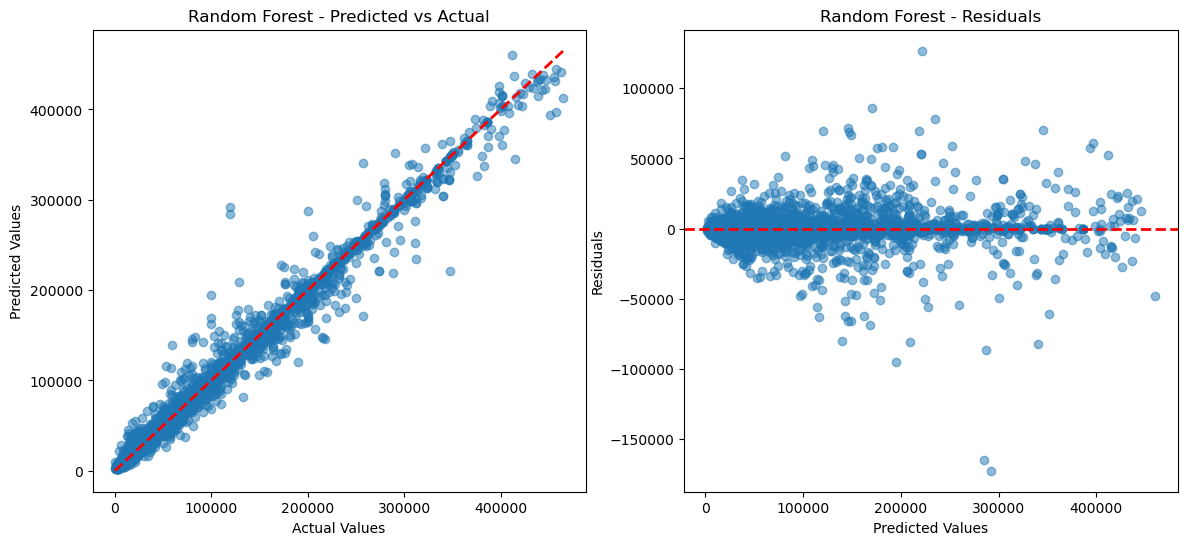

Gradient Boosting
MSE: 1223331749.7566, R²: 0.8296


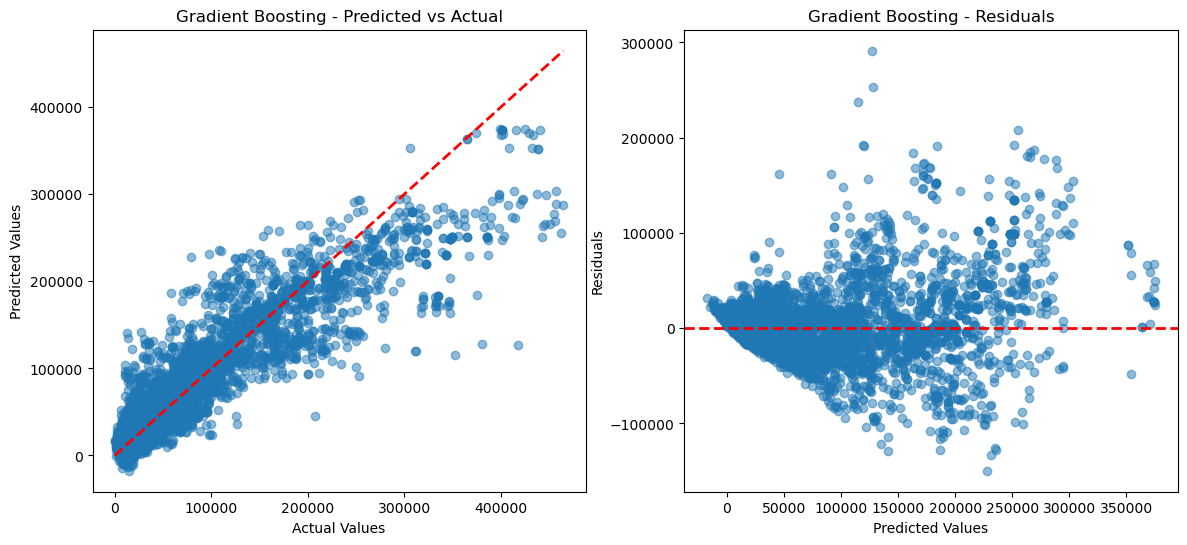

In [120]:
# Function to evaluate the model and plot evaluation metrics
def evaluate_and_plot_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print MSE and R² Score
    print(f'{model_name}')
    print(f'MSE: {mse:.4f}, R²: {r2:.4f}')

    # Predicted vs Actual values plot
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

    # Residuals plot
    residuals = y_test - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residuals')
    plt.axhline(y=0, color='r', linestyle='--', lw=2)

    plt.show()

# Initialize models
decision_tree_regressor = DecisionTreeRegressor(random_state=42)
random_forest_regressor = RandomForestRegressor(random_state=42)
gradient_boosting_regressor = GradientBoostingRegressor(random_state=42)

# Fit the models
decision_tree_regressor.fit(X_train, y_train)
random_forest_regressor.fit(X_train, y_train)
gradient_boosting_regressor.fit(X_train, y_train)

# Evaluate the models
models = [decision_tree_regressor, random_forest_regressor, gradient_boosting_regressor]
model_names = ['Decision Tree', 'Random Forest', 'Gradient Boosting']

for model, name in zip(models, model_names):
    evaluate_and_plot_model(model, name, X_test, y_test)

In [151]:
# Retrieve feature importances from the RandomForestRegressor model
importances = decision_tree_regressor.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

             Feature  Importance
1               item    0.598711
5   avg_temp_celsius    0.118289
3  pesticides_tonnes    0.114161
4    avg_rainfall_mm    0.079107
0               area    0.056531
2               year    0.033201


Sample Prediction